In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import library and data

In [ ]:

import string
import requests
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp drive/MyDrive/HabourSpace/CapstoneProject/thetaleofkieu.txt .

In [ ]:
ls

drive/  sample_data/  thetaleofkieu.txt


In [ ]:
with open("thetaleofkieu.txt", "r") as file:
    data = file.read()

# Preprocess the data

In [ ]:
data= data.replace("Advertisements","")
data=data.replace("REPORT THIS AD","")

In [ ]:
clean_data=[]
for line in data.splitlines():
  if line !='':
    clean_data.append(line)
  


In [ ]:
import re

def remove_numbers(string):
    return re.sub(r'\d+', '', string)

In [ ]:
clean_data=list(map(remove_numbers,clean_data))

In [ ]:
for ind,line in enumerate(clean_data):
  if line.split()[0]==".":
    clean_data[ind]=" ".join(line.split()[1:])

In [ ]:
len(clean_data)

3346

In [ ]:
clean_data[:5]

['Destiny is envious of genius',
 'Heaven is jealous with beauty',
 'In the hundred-year span of a human life,',
 'Talent and fate are always apt to strife.',
 'Through experience of a harrowing change,']

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
token = Tokenizer()
token.fit_on_texts(clean_data)

In [ ]:
file_path = "drive/MyDrive/HabourSpace/CapstoneProject/clean.txt"
with open(file_path, "w") as f:
    for line in clean_data:
        f.write(line + "\n")

In [ ]:
list(token.word_index.items())[:5]

[('the', 1), ('and', 2), ('of', 3), ('to', 4), ('a', 5)]

In [ ]:
encoded_text = token.texts_to_sequences(clean_data)
# vocabulary size should be + 1
vocab_size = len(token.word_counts) + 1
datalist = []
for d in encoded_text:
  if len(d)>1:
    for i in range(2, len(d)):
      datalist.append(d[:i])
      #print(d[:i])


In [ ]:
datalist[:5]

[[227, 22], [227, 22, 2324], [227, 22, 2324, 3], [92, 22], [92, 22, 560]]

In [ ]:
max_length = len(max(clean_data,key=len))
sequences = pad_sequences(datalist, maxlen=max_length, padding='pre')
X = sequences[:, :-1]
y = sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [ ]:
X.shape

(20888, 60)

In [ ]:
print(X.shape,y.shape)

(20888, 60) (20888, 4949)


In [ ]:
print(vocab_size,seq_length)

4949 60


# Building the model

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [ ]:
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras import regularizers

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=seq_length))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(vocab_size/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           494900    
                                                                 
 bidirectional (Bidirectiona  (None, 60, 300)          301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 2474)              249874    
                                                                 
 dense_1 (Dense)             (None, 4949)              12248775  
                                                        

In [ ]:
history=model.fit(X, y, batch_size=32, epochs=200)

Epoch 1/200
653/653 [==============================] - 21s 19ms/step - loss: 6.8639 - accuracy: 0.0496
Epoch 2/200
653/653 [==============================] - 17s 26ms/step - loss: 6.4197 - accuracy: 0.0523
Epoch 3/200
653/653 [==============================] - 15s 23ms/step - loss: 6.2548 - accuracy: 0.0609
Epoch 4/200
653/653 [==============================] - 17s 26ms/step - loss: 6.1355 - accuracy: 0.0694
Epoch 5/200
653/653 [==============================] - 13s 20ms/step - loss: 6.0375 - accuracy: 0.0755
Epoch 6/200
653/653 [==============================] - 13s 20ms/step - loss: 5.9452 - accuracy: 0.0817
Epoch 7/200
653/653 [==============================] - 13s 19ms/step - loss: 5.8561 - accuracy: 0.0885
Epoch 8/200
653/653 [==============================] - 14s 21ms/step - loss: 5.7719 - accuracy: 0.0940
Epoch 9/200
653/653 [==============================] - 14s 21ms/step - loss: 5.6826 - accuracy: 0.0986
Epoch 10/200
653/653 [==============================] - 13s 19ms/step - l

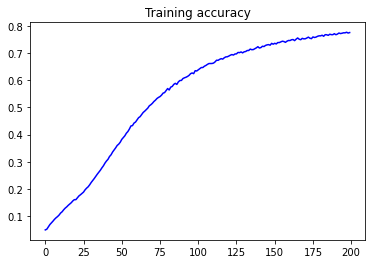

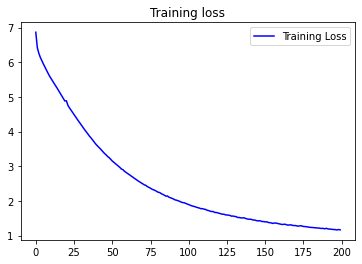

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generation the data

In [ ]:
poetry_length = 10
def generate_poetry(model,seed_text, n_lines):
  poem=[]
  for i in range(n_lines):
    text = []
    for _ in range(poetry_length):
      encoded = token.texts_to_sequences([seed_text])
      encoded = pad_sequences(encoded, maxlen=seq_length, padding='pre')

      y_pred = np.argmax(model.predict(encoded), axis=-1)

      predicted_word = ""
      for word, index in token.word_index.items():
        if index == y_pred:
          predicted_word = word
          break

      seed_text = seed_text + ' ' + predicted_word
      text.append(predicted_word)

    seed_text = text[-1]
    text = ' '.join(text)
    poem.append(text)
  return " \n".join(poem)

In [ ]:
seed_text = 'courage'
text=generate_poetry(model,seed_text, 5)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print(text)

whom was he fell in love and you’ll know how 
could i have the heart to cut off and depart 
incantations in tone high and bitter for her moon still 
when savoring fresh wind by the next twelve with through 
experience of a harrowing thoughts of my uncle over there


# Saving the model

In [ ]:
model.save('thetaleofkieu.h5') 

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
thetaleofkieu = Sequential()
thetaleofkieu.add(Embedding(vocab_size, 100, input_length=seq_length))
thetaleofkieu.add(Bidirectional(LSTM(150, return_sequences = True)))
thetaleofkieu.add(Dropout(0.2))
thetaleofkieu.add(LSTM(100))
thetaleofkieu.add(Dense(vocab_size/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
thetaleofkieu.add(Dense(vocab_size, activation='softmax'))
thetaleofkieu.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(thetaleofkieu.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           494900    
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 300)          301200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 60, 300)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 2474)              249874    
                                                                 
 dense_5 (Dense)             (None, 4949)              12248775  
                                                      

In [ ]:
thetaleofkieu.load_weights('thetaleofkieu.h5')

In [ ]:
seed_text = 'courage'
text=generate_poetry(thetaleofkieu,seed_text, 5)

1/1 [==============================] - 0s 26ms/step


In [ ]:
print(text)

whom was he fell in love and you’ll know how 
could i have the heart to cut off and depart 
incantations in tone high and bitter for her moon still 
when savoring fresh wind by the next twelve with through 
experience of a harrowing thoughts of my uncle over there
